In [1]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
output_dir = '/opt/ml/project-T4193/outputs'

pred_csv_filename = 'submission.csv'
pred_csv_path = os.path.join(output_dir, pred_csv_filename)

best_csv_filename = 'best_output.csv'
best_csv_path = os.path.join(output_dir, best_csv_filename)

pred_df = pd.read_csv(pred_csv_path)
best_df = pd.read_csv(best_csv_path)

In [3]:
pred_df['ans'].describe()

count    12600.000000
mean         4.781429
std          0.662397
min          0.000000
25%          5.000000
50%          5.000000
75%          5.000000
max         11.000000
Name: ans, dtype: float64

In [4]:
type(pred_df['ans'])

pandas.core.series.Series

In [5]:
# 라벨링이 잘 된건지 확인해보자.

In [6]:
# StratifiedShuffleSplit

data_dir = '/opt/ml/input/data/train' # 이게 뭐임?
df = pd.read_csv(os.path.join(data_dir, 'train.csv'))
paths = df['path'].to_numpy()
labels = (df['gender'].map({'male': 0, 'female': 1}) * 3 + df['age'] // 30)

s = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)
s.get_n_splits()
train_idx, valid_idx = next(s.split(paths, labels))

In [7]:
print(len(train_idx))
print(len(valid_idx))


2430
270


In [8]:
def _have_aug_image(path):
    path = str(path)
    age = int(path.split('_')[3])
    if age == 60:
        return True
    else:
        False
def _is_image(path):
    exts = ['jpg', 'jpeg', 'png']
    p = str(path)
    return '._' not in p and any(p.endswith(ext) for ext in exts)

# 60대 online augmentation 적용 - O

In [9]:
import os
import re
import glob
from pathlib import Path
from torch.utils.data import Dataset
from PIL import Image

class Aug60_Dataset(Dataset):
    def __init__(self, root, transform, train=True, paths=None):
        """
        csv 없이 파일 경로에서 라벨을 추출하는 데이터셋
        OfflineAug를 위해 제작함
        Args:
            root: 이미지가 들어있는 최상위 디렉터리
                  ex) '/opt/ml/input/data/train'
            transform:
            train:
        """
        self.root = root = Path(root)
        self.train = train
        self.transform = transform

        self.paths = []
        self.labels = []

        if paths is None:
            files = root.glob('**/*')
            self.paths = [f for f in files if self._is_image(f)]
        else:
            for path in paths:
                files = (root / 'images' / path).glob('*.*')
                files = [f for f in files if self._is_image(f)]
                self.paths.extend(files)
                
                # 60aug_image path 추가
                if _have_aug_image(path):
                    files = (root / '60aug_images' / path).glob('*.*')
                    files = [f for f in files if self._is_image(f)]
                    self.paths.extend(files)

        if train:
            for p in self.paths:
                self.labels.append(self._parse(p))


    def _is_image(self, path):
        exts = ['jpg', 'jpeg', 'png']
        p = str(path)
        return '._' not in p and any(p.endswith(ext) for ext in exts)


    def _parse(self, p):
        """
        path를 파싱해 라벨 리턴
        """
        p = str(p)
        match = re.search('_(.+)_Asian_(\d+)/(.*)[\.-]', p)
        if match and len(match.groups()) == 3:
            gender, age, mask = match.groups()
            gender = 0 if gender == 'male' else 1
            age = int(age)
            if age < 30:
                age = 0
            elif age < 60:
                age = 1
            else:
                age = 2

            if mask.startswith('normal'):
                mask = 2
            elif mask.startswith('incorrect'):
                mask = 1
            else:
                mask = 0

            return str((mask, gender,  age))
        else:
            raise Exception(f'Cannot parsing label from the path: {p}')


    def __getitem__(self, index):
        image = Image.open(self.paths[index])
        if self.transform:
            image = self.transform(image)
        if self.train:
            label = self.labels[index]
            return image, label
        return image, -1

    def __len__(self):
        return len(self.paths)

### valid_dataset 분포

In [10]:

valid_dataset = Aug60_Dataset('/opt/ml/input/data/train', None, paths=paths[valid_idx])
l = valid_dataset.labels
valid_df = pd.DataFrame(l, columns=['label'])
valid_df

,label
0,"(0, 1, 1)"
1,"(0, 1, 1)"
2,"(0, 1, 1)"
3,"(0, 1, 1)"
4,"(0, 1, 1)"
...,...
2550,"(0, 0, 1)"
2551,"(0, 0, 1)"
2552,"(0, 0, 1)"
2553,"(2, 0, 1)"


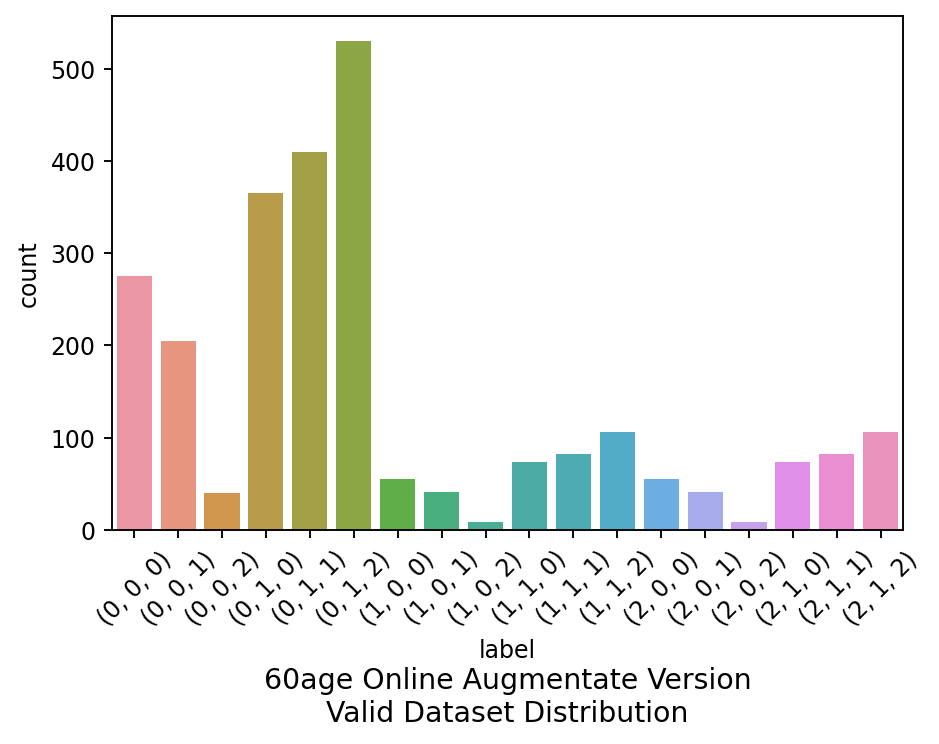

In [11]:
# valid_dataset 에 데이터 분포는 어떻게 될까?
plt.figure(dpi=170)
plt.xticks(rotation=45)
plt.title('60age Online Augmentate Version\nValid Dataset Distribution', y=-0.4)
sns.countplot(x='label', data=valid_df, order=sorted(valid_df['label'].unique()))

### Train dataset 분포

In [12]:
train_dataset = Aug60_Dataset('/opt/ml/input/data/train', None, paths=paths[train_idx])
l = train_dataset.labels
train_df = pd.DataFrame(l, columns=['label'])
train_df

,label
0,"(0, 1, 0)"
1,"(0, 1, 0)"
2,"(0, 1, 0)"
3,"(0, 1, 0)"
4,"(0, 1, 0)"
...,...
23060,"(0, 0, 0)"
23061,"(0, 0, 0)"
23062,"(0, 0, 0)"
23063,"(2, 0, 0)"


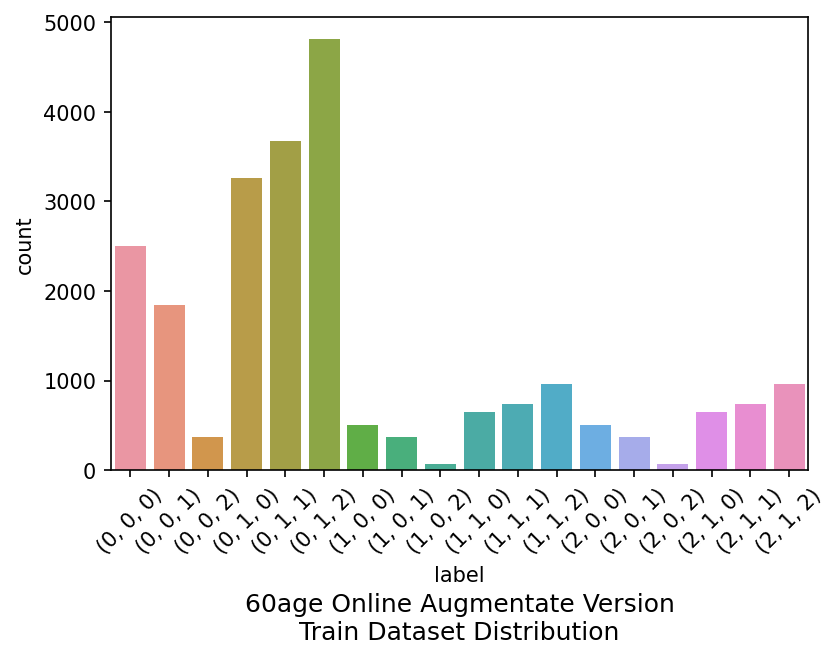

In [13]:
# train_dataset 에 데이터 분포는 어떻게 될까?
plt.figure(dpi=150)
plt.xticks(rotation=45)
plt.title('60age Online Augmentate Version\nTrain Dataset Distribution', y=-0.4)
sns.countplot(x='label', data=train_df, order=sorted(train_df['label'].unique()))

# 60대 online augmentation 적용 - X

In [16]:
import os
import re
import glob
from pathlib import Path
from torch.utils.data import Dataset
from PIL import Image

class MaskGlobDataset(Dataset):
    def __init__(self, root, transform, train=True, paths=None):
        """
        csv 없이 파일 경로에서 라벨을 추출하는 데이터셋
        OfflineAug를 위해 제작함
        Args:
            root: 이미지가 들어있는 최상위 디렉터리
                  ex) '/opt/ml/input/data/train'
            transform:
            train:
        """
        self.root = root = Path(root)
        self.train = train
        self.transform = transform

        self.paths = []
        self.labels = []

        if paths is None:
            files = root.glob('**/*')
            self.paths = [f for f in files if self._is_image(f)]
        else:
            for path in paths:
                files = (root / 'images' / path).glob('*.*')
                files = [f for f in files if self._is_image(f)]
                self.paths.extend(files)

        if train:
            for p in self.paths:
                self.labels.append(self._parse(p))


    def _is_image(self, path):
        exts = ['jpg', 'jpeg', 'png']
        p = str(path)
        return '._' not in p and any(p.endswith(ext) for ext in exts)


    def _parse(self, p):
        """
        path를 파싱해 라벨 리턴
        """
        p = str(p)
        match = re.search('_(.+)_Asian_(\d+)/(.*)[\.-]', p)
        if match and len(match.groups()) == 3:
            gender, age, mask = match.groups()
            gender = 0 if gender == 'male' else 1
            age = int(age)
            if age < 30:
                age = 0
            elif age < 60:
                age = 1
            else:
                age = 2

            if mask.startswith('normal'):
                mask = 2
            elif mask.startswith('incorrect'):
                mask = 1
            else:
                mask = 0

            return str((mask, gender,  age))
        else:
            raise Exception(f'Cannot parsing label from the path: {p}')


    def __getitem__(self, index):
        image = Image.open(self.paths[index])
        if self.transform:
            image = self.transform(image)
        if self.train:
            label = self.labels[index]
            return image, label
        return image, -1

    def __len__(self):
        return len(self.paths)

In [17]:
train_dataset = MaskGlobDataset('/opt/ml/input/data/train', None, paths=paths[train_idx])
l = train_dataset.labels
train_df = pd.DataFrame(l, columns=['label'])
train_df

,label
0,"(0, 1, 0)"
1,"(0, 1, 0)"
2,"(0, 1, 0)"
3,"(0, 1, 0)"
4,"(0, 1, 0)"
...,...
17005,"(0, 0, 0)"
17006,"(0, 0, 0)"
17007,"(0, 0, 0)"
17008,"(2, 0, 0)"


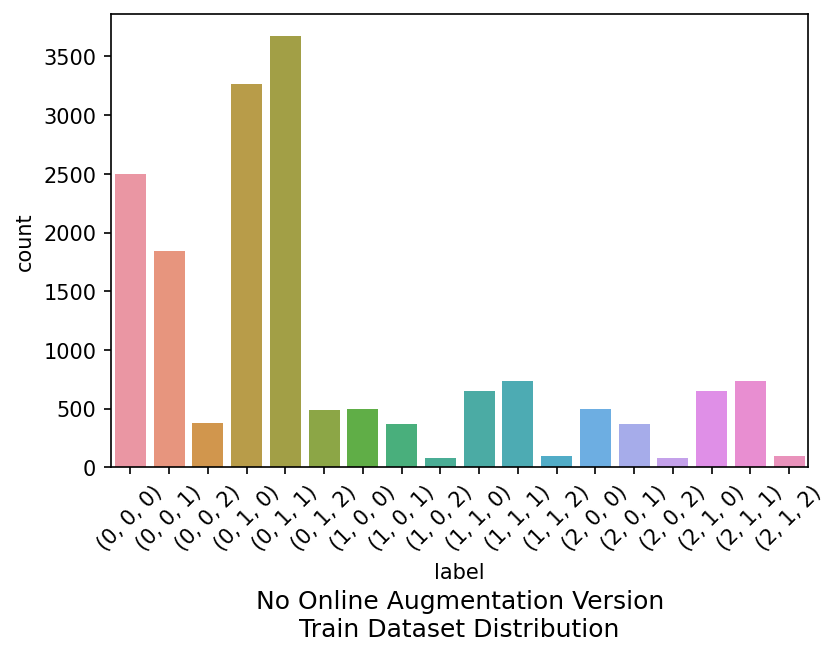

In [18]:
# train_dataset 에 데이터 분포는 어떻게 될까?
plt.figure(dpi=150)
plt.xticks(rotation=45)
plt.title('No Online Augmentation Version\nTrain Dataset Distribution', y=-0.4)
sns.countplot(x='label', data=train_df, order=sorted(train_df['label'].unique()))

In [19]:

valid_dataset = MaskGlobDataset('/opt/ml/input/data/train', None, paths=paths[valid_idx])
l = valid_dataset.labels
valid_df = pd.DataFrame(l, columns=['label'])
valid_df

,label
0,"(0, 1, 1)"
1,"(0, 1, 1)"
2,"(0, 1, 1)"
3,"(0, 1, 1)"
4,"(0, 1, 1)"
...,...
1885,"(0, 0, 1)"
1886,"(0, 0, 1)"
1887,"(0, 0, 1)"
1888,"(2, 0, 1)"


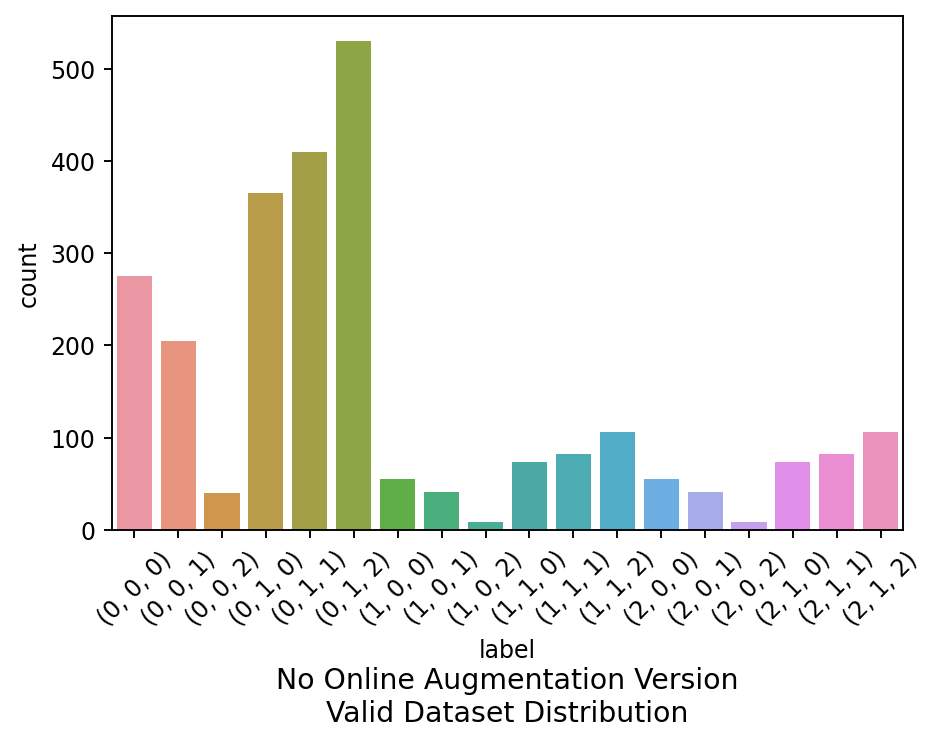

In [15]:
# valid_dataset 에 데이터 분포는 어떻게 될까?
plt.figure(dpi=170)
plt.xticks(rotation=45)
plt.title('No Online Augmentation Version\nValid Dataset Distribution', y=-0.4)
sns.countplot(x='label', data=valid_df, order=sorted(valid_df['label'].unique()))

In [20]:
data_dir = '/opt/ml/input/data/train' # 이게 뭐임?
df = pd.read_csv(os.path.join(data_dir, 'train.csv'))
paths = df['path'].to_numpy()

In [64]:
paths

array(['000001_female_Asian_45', '000002_female_Asian_52',
       '000004_male_Asian_54', ..., '006956_male_Asian_19',
       '006957_male_Asian_20', '006959_male_Asian_19'], dtype=object)

In [65]:
root

PosixPath('/opt/ml/input/data/train')

In [66]:
def is_age_60(path):
    age = int(path.split('_')[3])
    if age == 60:
        return True
    else:
        return False

In [79]:
from pathlib import Path

root = Path('/opt/ml/input/data/train')
total_paths = []
for path in paths:
    # path == '000001_female_Asian_45'
    files = (root / 'images' / path).glob('*.*')
    files = [f for f in files if _is_image(f)]
    total_paths.extend(files)
    
    # 60aug_image path 추가
    if is_age_60(path):
        # print(path)
        files = (root / '60aug-images' / path).glob('*.*')
        files = [f for f in files if _is_image(f)]
        total_paths.extend(files)
len(total_paths)

25620

In [80]:
# total_paths 에서 aug60_images 폴더에서 가져온 path를 찾아보자.
total_paths_df = pd.DataFrame(total_paths, columns=['path'])
total_paths_df.head()

,path
0,/opt/ml/input/data/train/images/000001_female_...
1,/opt/ml/input/data/train/images/000001_female_...
2,/opt/ml/input/data/train/images/000001_female_...
3,/opt/ml/input/data/train/images/000001_female_...
4,/opt/ml/input/data/train/images/000001_female_...


In [ ]:
total_paths_df[total_paths_df['path'] == re.()]

In [83]:
def _parse(p):
        """
        path를 파싱해 라벨 리턴
        """
        p = str(p)
        match = re.search('_(.+)_Asian_(\d+)/(.*)[\.-]', p)
        if match and len(match.groups()) == 3:
            gender, age, mask = match.groups()
            # gender = 0 if gender == 'male' else 1
            if gender == 'male':
                gender = 0
            else:
                gender = 1
            age = int(age)
            if age < 30:
                age = 0
            elif age < 60:
                age = 1
            else:
                age = 2

            if mask.startswith('normal'):
                mask = 2
            elif mask.startswith('incorrect'):
                mask = 1
            else:
                mask = 0           

            return str((mask, gender, age))
        else:
            raise Exception(f'Cannot parsing label from the path: {p}')
        

In [ ]:

for p in total_paths:
    print(p)
    print(_parse(p))
    # if _parse(p) == '(0, 1, 2)':
    #     print(p)

### 정규식 테스트

In [9]:
import re
# /opt/ml/input/data/train/60aug_images/001038_male_Asian_60/incorrect_mask_T5.jpg 에서 age, gender, mask 정규식으로 뽑아보자.
p = '/opt/ml/input/data/train/60aug-images/001038_male_Asian_60/mask2_T3.jpg'
match = re.search('_(.+)_Asian_(\d+)/(.*)[\.-]', p)
gender, age, mask = match.groups()
# gender = 0 if gender == 'male' else 1
print(f"mask : {mask}")
print(f"gender : {gender}")
print(f"age : {age}")


mask : mask2_T3
gender : male
age : 60


In [84]:
labels = []
for p in total_paths:
    labels.append(_parse(p))
len(labels)


25620

In [85]:
total_labels_df = pd.DataFrame(labels, columns=['label'])
total_labels_df.head()

,label
0,"(0, 1, 1)"
1,"(0, 1, 1)"
2,"(0, 1, 1)"
3,"(0, 1, 1)"
4,"(0, 1, 1)"


In [51]:
print(total_labels_df['label'][1])
print(type(total_labels_df['label'][1]))

(0, 1, 1)
<class 'str'>


In [86]:
print(total_labels_df[total_labels_df['label'] == '(0, 0, 0)'].count())
print(total_labels_df[total_labels_df['label'] == '(0, 0, 1)'].count())
print(total_labels_df[total_labels_df['label'] == '(0, 0, 2)'].count())
print(total_labels_df[total_labels_df['label'] == '(0, 1, 0)'].count())
print(total_labels_df[total_labels_df['label'] == '(0, 1, 1)'].count())
print(total_labels_df[total_labels_df['label'] == '(0, 1, 2)'].count())
print(total_labels_df[total_labels_df['label'] == '(1, 0, 0)'].count())
print(total_labels_df[total_labels_df['label'] == '(1, 0, 1)'].count())
print(total_labels_df[total_labels_df['label'] == '(1, 0, 2)'].count())
print(total_labels_df[total_labels_df['label'] == '(1, 1, 0)'].count())
print(total_labels_df[total_labels_df['label'] == '(1, 1, 1)'].count())
print(total_labels_df[total_labels_df['label'] == '(1, 1, 2)'].count())
print(total_labels_df[total_labels_df['label'] == '(2, 0, 0)'].count())
print(total_labels_df[total_labels_df['label'] == '(2, 0, 1)'].count())
print(total_labels_df[total_labels_df['label'] == '(2, 0, 2)'].count())
print(total_labels_df[total_labels_df['label'] == '(2, 1, 0)'].count())
print(total_labels_df[total_labels_df['label'] == '(2, 1, 1)'].count())
print(total_labels_df[total_labels_df['label'] == '(2, 1, 2)'].count())

label    2775
dtype: int64
label    2050
dtype: int64
label    2490
dtype: int64
label    3630
dtype: int64
label    4085
dtype: int64
label    3270
dtype: int64
label    555
dtype: int64
label    410
dtype: int64
label    498
dtype: int64
label    726
dtype: int64
label    817
dtype: int64
label    654
dtype: int64
label    555
dtype: int64
label    410
dtype: int64
label    498
dtype: int64
label    726
dtype: int64
label    817
dtype: int64
label    654
dtype: int64


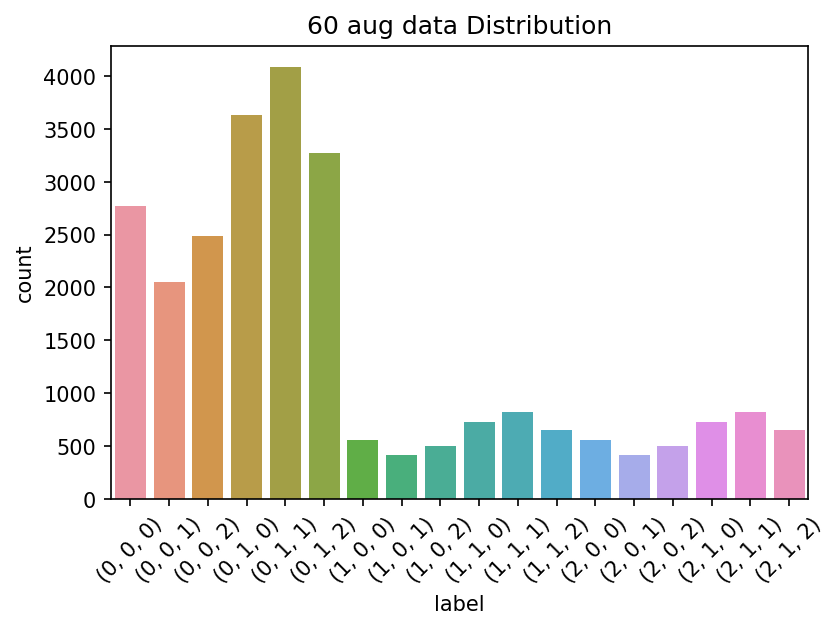

In [87]:
# paths를 참고해서 label 분포를 확인해보자.
plt.figure(dpi=150)
plt.xticks(rotation=45)
plt.title('60 aug data Distribution')

sns.countplot(x='label', data=total_labels_df, order=sorted(total_labels_df['label'].unique()))